In [135]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


/home1/giorgian/anaconda3/envs/jupyter/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [136]:
import torch
import pickle
import dataloaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_Masked import Bipartite_Attention as Model
import matplotlib as mpl
import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score
import os
plt.style.use('ggplot')

In [137]:
from importlib import reload

In [8]:
config_file_path = '/disks/disk1/giorgian/old-trainings/train_results/biatt-augment-adj/experiment_2025-05-19_14:23:56/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [138]:
config_file_path = '/disks/disk1/giorgian/old-trainings/train_results/biatt-augment-adj/experiment_2025-05-19_14:23:56/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)
dconfig = {k:v for k, v in config['data'].items()}

dconfig['name'] = 'tracks'
dconfig['n_train'] = 72//2
dconfig['n_valid'] = 72//2
dconfig['n_test'] = 0
dconfig['trigger_input_dir'] =  '/home1/giorgian/real-data/parsed-tracks/trigger/events/'
dconfig['nontrigger_input_dir'] =  '/home1/giorgian/real-data/parsed-tracks/nontrigger/events/'
dconfig['batch_size'] = 1
#dconfig['load_complete_graph'] = False
dconfig['drop_nontrigger_percentage'] = 0
#del dconfig['add_geo_features'], dconfig['load_complete_graph'], dconfig['use_physics_pred']
#
train_data, val_data, test_data = dataloaders.get_data_loaders(**dconfig)


In [10]:
config['model']

{'aggregator_activation': 'softmax',
 'bn': False,
 'hidden_activation': 'PReLU',
 'ln': True,
 'num_classes': 2,
 'num_features': 37,
 'recalculate_hits_mean': True,
 'self_split': False,
 'layers_spec': [[64, 16], [64, 16], [64, 16]]}

In [139]:
DEVICE = 'cuda:0'

#config_file_path = '/disks/disk1/giorgian/old-trainings/train_results/biatt-augment-adj/experiment_2025-05-29_01:56:45/config.pkl' # With predicting trigger node
config_file_path = '/disks/disk1/giorgian/old-trainings/train_results/biatt-augment-adj/experiment_2025-05-30_07:07:57/config.pkl' # With dropping all non-trigger
config_file_path = '/disks/disk1/giorgian/old-trainings/train_results/biatt-augment-adj/experiment_2025-06-05_12:56:31/config.pkl' # With dropping all non-trigger, and perturbations

with open(config_file_path, 'rb') as f:
    config = pickle.load(f)
# α=0.7
checkpoint_file = os.path.join(os.path.dirname(config_file_path), 'checkpoints/model_checkpoint_016.pth.tar')

mconfig = config['model']
model = Model(**mconfig)
oconfig = config['optimizer']
params = model.parameters()
if config['optimizer']['type'] == 'Adam':
    optimizer = torch.optim.Adam(params=params,
            lr=oconfig['learning_rate'],
            weight_decay=oconfig['weight_decay'],
            betas=[oconfig['beta_1'], oconfig['beta_2']],
            eps=oconfig['eps']
    )
elif oconfig['type'] == 'SGD':
    optimizer = torch.optim.SGD(params=params, lr=oconfig['learning_rate'], momentum=oconfig['momentum'], weight_decay=oconfig['weight_decay'])
model, optimizer = load_checkpoint(checkpoint_file, model, optimizer=optimizer)
model = model.to(DEVICE)
model.eval()
for p_state in optimizer.state.values():
    for k, v in p_state.items():
        if isinstance(v, torch.Tensor):
            p_state[k] = v.to(DEVICE)

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST/utils/log.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(c

In [140]:
trigger_preds = []
track_vectors = []
trigger_labels = []
trigger_nodes = []
trigger_nodes_preds = []
trigger_preds_tcount = []
labels = []
TOTAL = len(val_data)
model.eval()
for batch, mask in tqdm(islice(val_data, 0, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    trigger_nodes.append(batch.trigger_node[mask.to(torch.bool)])
    if tracks.shape[1] == 0:
        continue
        
    mask = mask.to(DEVICE)
    _, preds, trigger_node_preds = model.generate_track_embeddings(tracks, mask)
    tcount = torch.sum(torch.argmax(trigger_node_preds, dim=-1) == 1, dim=-1)
    trigger_preds.extend(preds[:, -1].detach().cpu().numpy())
    trigger_nodes_preds.append(trigger_node_preds[mask.to(torch.bool)])
    track_vectors.extend(batch.track_vector.cpu().numpy())
    trigger_preds_tcount.extend(tcount.cpu().numpy())
    trigger_labels.append(batch.trigger)
    #print(f'{batch.trigger_node=} {batch.track_vector.shape=} {batch.trigger=}')
trigger_preds = np.array(trigger_preds)
trigger_labels = np.array(trigger_labels)
trigger_preds_tcount = np.array(trigger_preds_tcount)

  0%|          | 0/72 [00:00<?, ?it/s]

In [141]:
counts = []
for i in range(len(trigger_labels)):
    if trigger_labels[i] == True:
        counts.append(len(track_vectors[i]))

(array([3., 6., 7., 8., 1., 3., 1., 1., 1., 1.]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ]),
 <BarContainer object of 10 artists>)

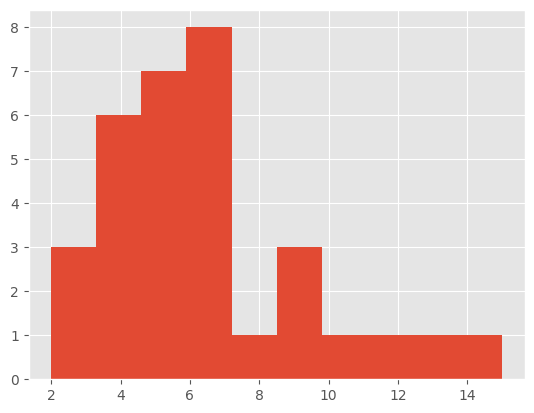

In [142]:
plt.hist(counts)

In [143]:
np.mean(np.array(counts) == 2)*100

np.float64(9.375)

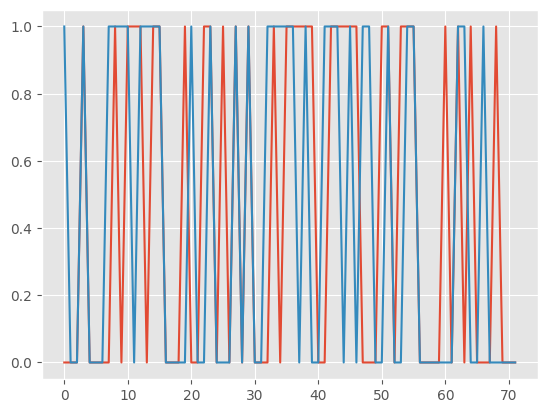

In [144]:
plt.plot(trigger_preds > 0)
plt.plot(trigger_labels)

Text(0, 0.5, 'accuracy')

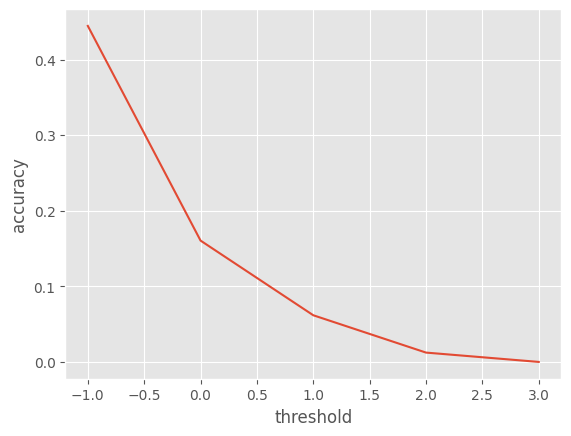

In [145]:
accs = []
ts = []
for threshold in [-1, 0, 1, 2, 3]:
    ts.append(threshold)
    accs.append(np.mean(trigger_labels*(trigger_preds_tcount > threshold)))
plt.plot(ts, accs)
plt.xlabel('threshold')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

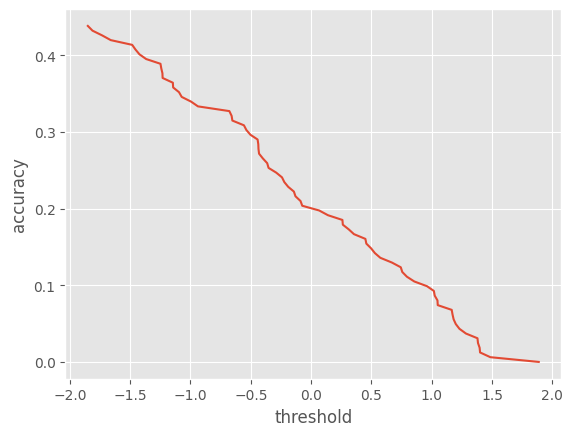

In [146]:
accs = []
ts = []
for threshold in np.unique(trigger_preds):
    ts.append(threshold)
    accs.append(np.mean(trigger_labels*(trigger_preds > threshold)))
plt.plot(ts, accs)
plt.xlabel('threshold')
plt.ylabel('accuracy')

28.55


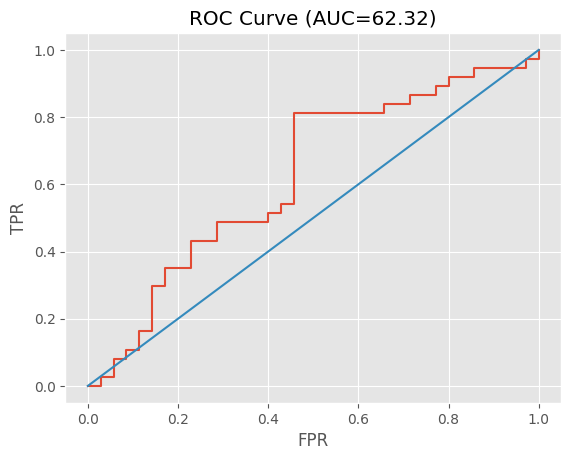

In [126]:
fpr, tpr, thresholds = roc_curve(trigger_labels, trigger_preds)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (AUC={roc_auc_score(trigger_labels, trigger_preds)*100:.2f})')
plt.plot([0, 1], [0, 1])
print(f'{np.mean((trigger_labels)*(trigger_preds > 0))*100:.2f}')

In [ ]:
fpr, tpr, thresholds = roc_curve(trigger_labels, trigger_preds)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (AUC={roc_auc_score(trigger_labels, trigger_preds)*100:.2f})')
plt.plot([0, 1], [0, 1])
print(f'{np.mean((trigger_labels)*(trigger_preds > 0))*100:.2f}')

27.12


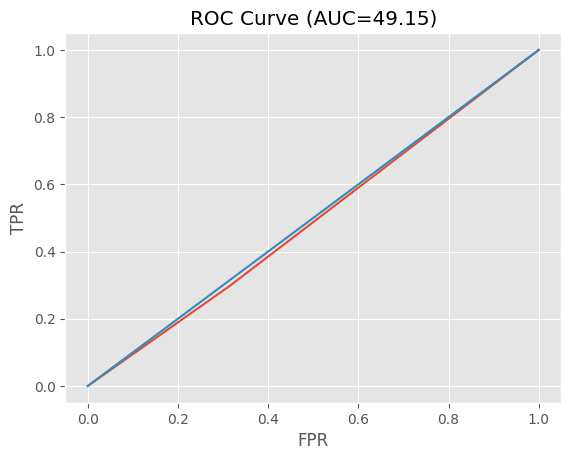

In [118]:
fpr, tpr, thresholds = roc_curve(trigger_labels, trigger_preds_tcount)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (AUC={roc_auc_score(trigger_labels, trigger_preds_tcount)*100:.2f})')
plt.plot([0, 1], [0, 1])
print(f'{np.mean((trigger_labels)*(trigger_preds > 0))*100:.2f}')

In [26]:
np.mean(trigger_labels*(trigger_preds > 0))

np.float64(0.21257716049382716)

In [27]:
np.mean(trigger_labels*(trigger_preds > 0))

np.float64(0.21257716049382716)

In [14]:
np.mean(trigger_labels*(trigger_preds < 0))

np.float64(0.2892283277127554)

In [111]:
trigger_preds < 0

array([ True,  True, False, False, False,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True,  True,  True, False, False, False,  True, False,  True,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True, False, False,  True,  True,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
        True,  True,  True,  True, False,  True, False, False, False,
        True, False, False, False, False, False,  True,  True, False,
        True, False, False,  True,  True, False,  True, False, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True, False, False, False, False,  True,  True, False, False,
        True,  True,

In [11]:
np.mean([len(tv) for tv in track_vectors])

np.float64(6.52112676056338)

In [74]:
np.mean(np.array(trigger_preds) > 0).item()*100

60.56338028169014

In [46]:
batch.trigger_node, batch.track_vector.shape

(tensor([0., 1., 1., 0., 0.]), torch.Size([1, 5, 37]))

In [17]:
nontrigger_preds = []
track_vectors = []
TOTAL = int(10e3)
model.eval()
for batch, mask in tqdm(islice(val_data, 0, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
        
    mask = (mask * (~batch.trigger_node.to(torch.bool))).to(DEVICE) 
    nontrigger_preds.extend(model(tracks, mask)[:, -1].detach().cpu().numpy())
    track_vectors.extend(batch.track_vector.cpu().numpy())

nontrigger_preds = np.array(nontrigger_preds)

  0%|          | 0/10000 [00:00<?, ?it/s]

RuntimeError: shape '[1, 2, 5, 3]' is invalid for input of size 60

In [76]:
np.mean(np.array(nontrigger_preds) > 0).item()*100

42.25352112676056

In [16]:
thresholds = np.unique(np.concatenate([trigger_preds, nontrigger_preds]))

In [17]:
thresholds

array([-4.7622595 , -2.7164977 , -2.173026  , -2.125841  , -2.1195264 ,
       -2.0709488 , -2.0481584 , -1.9852026 , -1.8839657 , -1.8368502 ,
       -1.7471566 , -1.5634375 , -1.5062262 , -1.4949632 , -1.4527297 ,
       -1.1789963 , -1.1730459 , -1.1691802 , -1.1573035 , -1.0537739 ,
       -1.0494274 , -1.0108399 , -0.9739859 , -0.9715971 , -0.92208475,
       -0.83643764, -0.7676793 , -0.7454579 , -0.7058319 , -0.6715111 ,
       -0.64513636, -0.63520724, -0.5823704 , -0.56846464, -0.52894443,
       -0.4966774 , -0.48514706, -0.47812164, -0.4553821 , -0.44850096,
       -0.41570878, -0.38589898, -0.35988122, -0.35139257, -0.34597346,
       -0.30291763, -0.30286533, -0.30278993, -0.25042564, -0.23979583,
       -0.23372358, -0.20058882, -0.18753439, -0.16307348, -0.16124687,
       -0.15405959, -0.09879181, -0.09598788, -0.09419899, -0.08904812,
       -0.08097337, -0.05807906, -0.05441467, -0.04420199, -0.04038484,
       -0.03822196, -0.00808918,  0.04274103,  0.05325871,  0.05

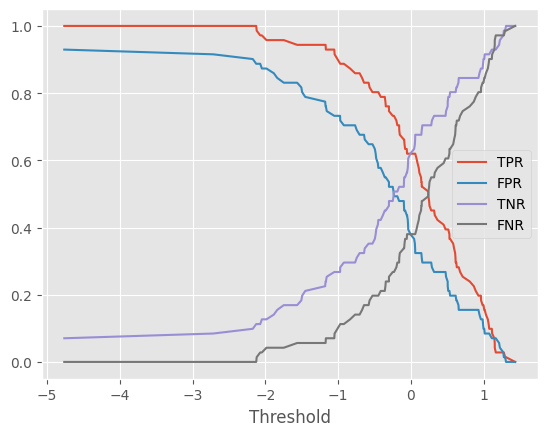

In [18]:
plt.style.use('ggplot')
tpr = [np.mean(trigger_preds > threshold) for threshold in thresholds]
fpr = [np.mean(nontrigger_preds > threshold) for threshold in thresholds]
tnr = [np.mean(nontrigger_preds <= threshold) for threshold in thresholds]
fnr = [np.mean(trigger_preds <= threshold) for threshold in thresholds]


plt.plot(thresholds, tpr, label='TPR')
plt.plot(thresholds, fpr, label='FPR')
plt.plot(thresholds, tnr, label='TNR')
plt.plot(thresholds, fnr, label='FNR')

plt.xlabel('Threshold')
plt.legend()

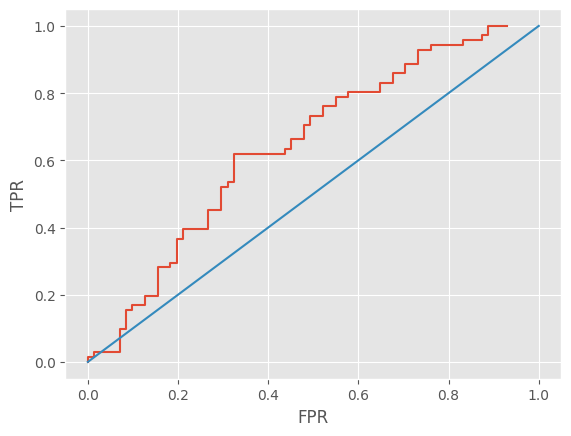

In [19]:
plt.style.use('ggplot')
tpr = [np.mean(trigger_preds > threshold) for threshold in thresholds]
fpr = [np.mean(nontrigger_preds > threshold) for threshold in thresholds]
tnr = [np.mean(nontrigger_preds <= threshold) for threshold in thresholds]
fnr = [np.mean(trigger_preds <= threshold) for threshold in thresholds]


plt.plot(fpr, tpr)


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(np.linspace(0, 1), np.linspace(0, 1))


(array([3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 2., 0., 1., 1., 0., 2.,
        0., 2., 0., 1., 2., 1., 1., 2., 2., 3., 1., 0., 3., 4., 0., 5., 1.,
        1., 1., 1., 2., 6., 1., 1., 1., 2., 1., 4., 3., 5., 0., 1., 1.]),
 array([0.1072134 , 0.12120983, 0.13520625, 0.14920267, 0.16319911,
        0.17719553, 0.19119197, 0.20518839, 0.21918482, 0.23318124,
        0.24717766, 0.26117408, 0.27517053, 0.28916696, 0.30316338,
        0.3171598 , 0.33115622, 0.34515265, 0.3591491 , 0.37314552,
        0.38714194, 0.40113837, 0.41513479, 0.42913124, 0.44312766,
        0.45712408, 0.47112051, 0.48511693, 0.49911335, 0.5131098 ,
        0.52710623, 0.54110265, 0.55509907, 0.56909549, 0.58309191,
        0.59708834, 0.61108476, 0.62508118, 0.6390776 , 0.65307403,
        0.66707045, 0.68106687, 0.69506329, 0.70905972, 0.72305614,
        0.73705262, 0.75104904, 0.76504546, 0.77904189, 0.79303831,
        0.80703473]),
 <BarContainer object of 50 artists>)

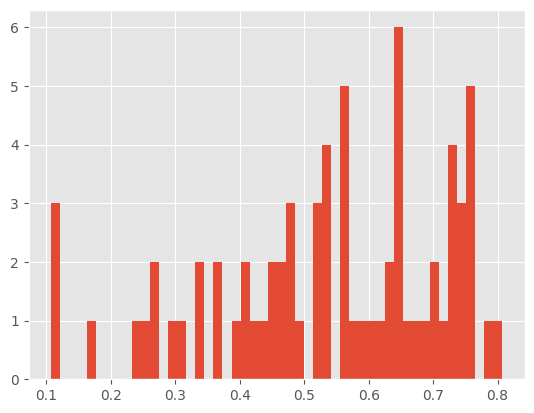

In [20]:
plt.hist(1/(1 + np.exp(-trigger_preds)), bins=50)

(array([5., 0., 0., 1., 0., 0., 3., 1., 2., 0., 0., 3., 0., 0., 3., 0., 1.,
        2., 0., 0., 2., 1., 1., 2., 3., 2., 2., 2., 1., 0., 6., 1., 4., 1.,
        1., 0., 2., 0., 0., 4., 1., 3., 0., 0., 0., 2., 3., 1., 1., 4.]),
 array([0.00847386, 0.02403743, 0.03960099, 0.05516456, 0.07072813,
        0.0862917 , 0.10185527, 0.11741884, 0.1329824 , 0.14854598,
        0.16410954, 0.17967312, 0.19523668, 0.21080026, 0.22636382,
        0.2419274 , 0.25749096, 0.27305451, 0.28861809, 0.30418167,
        0.31974521, 0.33530879, 0.35087237, 0.36643595, 0.38199949,
        0.39756307, 0.41312665, 0.4286902 , 0.44425377, 0.45981735,
        0.47538093, 0.49094447, 0.50650805, 0.52207166, 0.53763521,
        0.55319881, 0.56876236, 0.58432591, 0.59988952, 0.61545306,
        0.63101661, 0.64658022, 0.66214377, 0.67770731, 0.69327092,
        0.70883447, 0.72439808, 0.73996162, 0.75552517, 0.77108878,
        0.78665233]),
 <BarContainer object of 50 artists>)

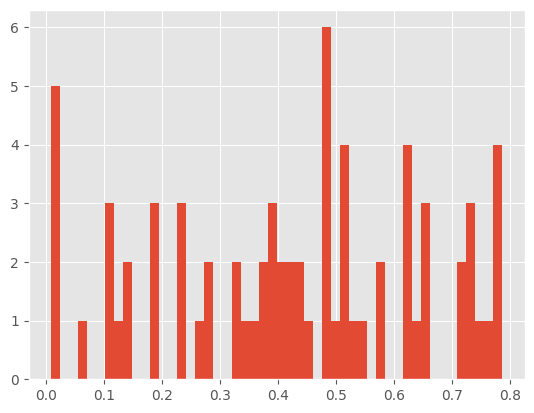

In [21]:
plt.hist(1/(1 + np.exp(-nontrigger_preds)), bins=50)

# Fine-Tune

In [12]:
trigger_preds = []
track_vectors = []
TOTAL = len(val_data)
model = model.to(DEVICE)
model.train()
for i in range(10):
    for batch, mask in tqdm(islice(train_data, 0, TOTAL), total=TOTAL):
        tracks = batch.track_vector.to(DEVICE)
        trigger = batch.trigger.to(DEVICE).to(torch.long)
        if tracks.shape[1] == 0:
            continue
        loss = 0
        mask = mask.to(DEVICE)
        pred_labels = model(tracks, mask)
        ce_loss = F.cross_entropy(pred_labels, trigger)
        loss += ce_loss
    
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

31.73


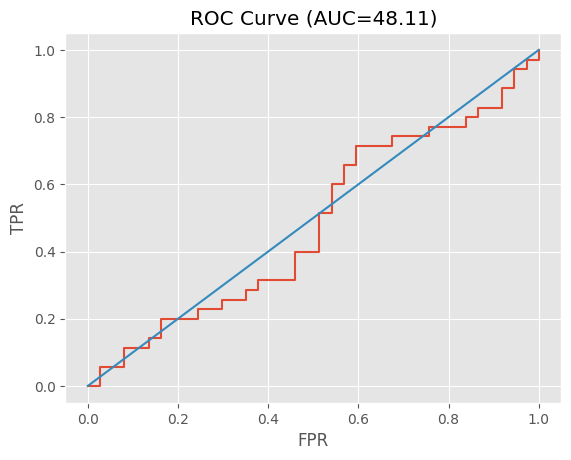

In [13]:
trigger_preds = []
track_vectors = []
trigger_labels = []
labels = []
TOTAL = len(val_data)
model.eval()
for batch, mask in tqdm(islice(val_data, 0, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
        
    mask = mask.to(DEVICE)
    trigger_preds.extend(model(tracks, mask)[:, -1].detach().cpu().numpy())
    track_vectors.extend(batch.track_vector.cpu().numpy())
    trigger_labels.append(batch.trigger)
    #print(f'{batch.trigger_node=} {batch.track_vector.shape=} {batch.trigger=}')
trigger_preds = np.array(trigger_preds)
trigger_labels = np.array(trigger_labels)

fpr, tpr, thresholds = roc_curve(trigger_labels, trigger_preds)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (AUC={roc_auc_score(trigger_labels, trigger_preds)*100:.2f})')
plt.plot([0, 1], [0, 1])
print(f'{np.mean((trigger_labels)*(trigger_preds > 0))*100:.2f}')

In [84]:
trigger_preds = []
track_vectors = []
TOTAL = 40
model.train()
for batch, mask in tqdm(islice(val_data, 0, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
    loss = 0
    mask = mask.to(DEVICE)
    pred_labels = model(tracks, mask)
    ce_loss = F.cross_entropy(pred_labels, torch.ones(tracks.shape[0], device=DEVICE, dtype=torch.long))
    loss += ce_loss


    mask = mask * (~batch.trigger_node.to(torch.bool).to(DEVICE))
    pred_labels = model(tracks, mask)
    ce_loss = F.cross_entropy(pred_labels, torch.zeros(tracks.shape[0], device=DEVICE, dtype=torch.long))
    loss += ce_loss

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

  0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
trigger_preds = []
track_vectors = []
trigger_labels = []
TOTAL = int(10e3)
model.eval()
for batch, mask in tqdm(islice(val_data, 40, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
        
    mask = mask.to(DEVICE)
    trigger_preds.extend(model(tracks, mask)[:, -1].detach().cpu().numpy())
    track_vectors.extend(batch.track_vector.cpu().numpy())
    trigger_labels.append(batch.trigger)

trigger_preds = np.array(trigger_preds)
trigger_labels = np.array(trigger_labels)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
np.mean((np.array(trigger_preds) > 0)*trigger_labels).item()*100

11.7603550295858

In [87]:
nontrigger_preds = []
track_vectors = []
TOTAL = int(10e3)
model.eval()
for batch, mask in tqdm(islice(val_data, 40, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
        
    mask = (mask * (~batch.trigger_node.to(torch.bool))).to(DEVICE) 
    nontrigger_preds.extend(model(tracks, mask)[:, -1].detach().cpu().numpy())
    track_vectors.extend(batch.track_vector.cpu().numpy())

nontrigger_preds = np.array(nontrigger_preds)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [88]:
np.mean(np.array(nontrigger_preds) > 0).item()*100

45.16129032258064

In [ ]:
Model

In [51]:
import torch
from models.Bipartite_Attention_Old import Bipartite_Attention as Model

DEVICE = 'cuda:0'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)


mconfig = config["model"]
oconfig = config["optimizer"]

model = Model(**mconfig)

# load the checkpoint *weights only* and keep the Adam moments fresh
model = load_checkpoint(checkpoint_file, model, optimizer=None)

for p in model.parameters():                # freeze everything …
    p.requires_grad = False

for p in model._pred_layers[2].parameters():  # … except the last block
    p.requires_grad = True

params = model._pred_layers[2].parameters()

if oconfig["type"] == "Adam":
    optimizer = torch.optim.Adam(
        params=params,
        lr=oconfig["learning_rate"],
        weight_decay=oconfig["weight_decay"],
        betas=[oconfig["beta_1"], oconfig["beta_2"]],
        eps=oconfig["eps"],
    )
elif oconfig["type"] == "SGD":
    optimizer = torch.optim.SGD(
        params=params,
        lr=oconfig["learning_rate"],
        momentum=oconfig["momentum"],
        weight_decay=oconfig["weight_decay"],
    )
else:
    raise ValueError(f"Unsupported optimizer {oconfig['type']}")

# ─────────────────────────── device placement ────────────────────────────────
model = model.to(DEVICE)
model.eval()                                # keep the call to match original style

# the optimiser has no state yet, but move anything that appears later
for p_state in optimizer.state.values():
    for k, v in p_state.items():
        if isinstance(v, torch.Tensor):
            p_state[k] = v.to(DEVICE)


/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST/utils/log.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(c

In [49]:
trigger_preds = []
track_vectors = []
TOTAL = len(val_data)
model = model.to(DEVICE)
model.train()
for i in range(2):
    for batch, mask in tqdm(islice(train_data, 0, TOTAL), total=TOTAL):
        tracks = batch.track_vector.to(DEVICE)
        trigger = batch.trigger.to(DEVICE).to(torch.long)
        if tracks.shape[1] == 0:
            continue
        loss = 0
        mask = mask.to(DEVICE)
        pred_labels = model(tracks, mask)
        ce_loss = F.cross_entropy(pred_labels, trigger)
        loss += ce_loss
    
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

22.28


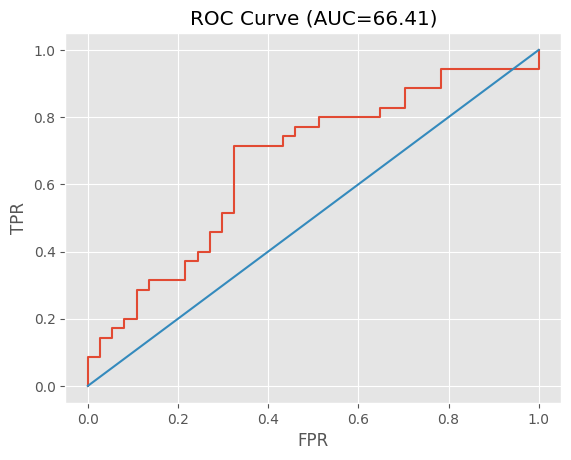

In [52]:
trigger_preds = []
track_vectors = []
trigger_labels = []
labels = []
TOTAL = len(val_data)
model.eval()
for batch, mask in tqdm(islice(val_data, 0, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
        
    mask = mask.to(DEVICE)
    trigger_preds.extend(model(tracks, mask)[:, -1].detach().cpu().numpy())
    track_vectors.extend(batch.track_vector.cpu().numpy())
    trigger_labels.append(batch.trigger)
    #print(f'{batch.trigger_node=} {batch.track_vector.shape=} {batch.trigger=}')
trigger_preds = np.array(trigger_preds)
trigger_labels = np.array(trigger_labels)

fpr, tpr, thresholds = roc_curve(trigger_labels, trigger_preds)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (AUC={roc_auc_score(trigger_labels, trigger_preds)*100:.2f})')
plt.plot([0, 1], [0, 1])
print(f'{np.mean((trigger_labels)*(trigger_preds > 0))*100:.2f}')

In [69]:
trigger_preds = []
track_vectors = []
TOTAL = int(10e3)
model.eval()
for batch, mask in tqdm(islice(val_data, 40, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
        
    mask = mask.to(DEVICE)
    trigger_preds.extend(model(tracks, mask)[:, -1].detach().cpu().numpy())
    track_vectors.extend(batch.track_vector.cpu().numpy())
trigger_preds = np.array(trigger_preds)
np.mean(np.array(trigger_preds) > 0).item()*100

  0%|          | 0/10000 [00:00<?, ?it/s]

100.0

In [59]:
nontrigger_preds = []
track_vectors = []
TOTAL = int(10e3)
model.eval()
for batch, mask in tqdm(islice(val_data, 40, TOTAL), total=TOTAL):
    tracks = batch.track_vector.to(DEVICE)
    if tracks.shape[1] == 0:
        continue
        
    mask = (mask * (~batch.trigger_node.to(torch.bool))).to(DEVICE) 
    nontrigger_preds.extend(model(tracks, mask)[:, -1].detach().cpu().numpy())
    track_vectors.extend(batch.track_vector.cpu().numpy())

nontrigger_preds = np.array(nontrigger_preds)
np.mean(np.array(nontrigger_preds) > 0).item()*100

  0%|          | 0/10000 [00:00<?, ?it/s]

54.83870967741935